In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [4]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [5]:
data = read_text("/content/drive/MyDrive/Colab Notebooks/TUKL summer internship/week1/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [6]:
deu_eng = deu_eng[:50000,:]

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn', 'Wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together', 'Wir waren zusammen auf Reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together', 'Wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [9]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['we took a wrong turn', 'wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['we traveled together', 'wir waren zusammen auf reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['we traveled together', 'wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

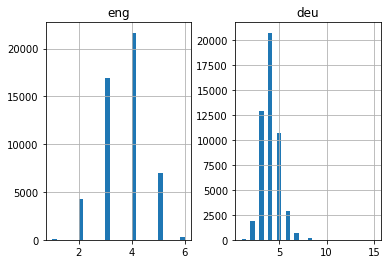

In [10]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [11]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [12]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6152


In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10112


In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [15]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [16]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [18]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [19]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 33s 178ms/step - loss: 4.3161 - acc: 0.5142 - val_loss: 2.7858 - val_acc: 0.5755
Epoch 2/30
63/63 [==============================] - 9s 138ms/step - loss: 2.7209 - acc: 0.5814 - val_loss: 2.6904 - val_acc: 0.5830
Epoch 3/30
63/63 [==============================] - 9s 139ms/step - loss: 2.5821 - acc: 0.5925 - val_loss: 2.5246 - val_acc: 0.6093
Epoch 4/30
63/63 [==============================] - 9s 137ms/step - loss: 2.3968 - acc: 0.6173 - val_loss: 2.3899 - val_acc: 0.6249
Epoch 5/30
63/63 [==============================] - 9s 137ms/step - loss: 2.2374 - acc: 0.6325 - val_loss: 2.2501 - val_acc: 0.6413
Epoch 6/30
63/63 [==============================] - 9s 137ms/step - loss: 2.0908 - acc: 0.6506 - val_loss: 2.1499 - val_acc: 0.6562
Epoch 7/30
63/63 [==============================] - 9s 137ms/step - loss: 1.9569 - acc: 0.6641 - val_loss: 2.0538 - val_acc: 0.6671
Epoch 8/30
63/63 [==============================] - 9s 138ms/step - loss: 1

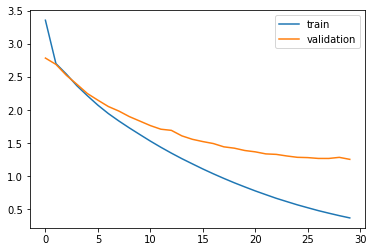

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [22]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [23]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [24]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [25]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [26]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
3876,why are we poor,why are we poor
5586,the choice is yours,its to
7506,tom seems insincere,tom seems upset
8754,lets look upstairs,be looking
6338,tom looks tired,tom looks tired
5678,the kids are asleep,the kids books
2127,everybody cheered,everybody applauded
6862,i dont have a radio,i have no a
5933,can i pay later,can i take you
4375,i was aware of that,i saw that
